<a href="https://colab.research.google.com/github/Orixtosius/Computer-Vision-Exercises/blob/main/SSD_Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 76630, done.
remote: Counting objects: 100% (451/451), done.
remote: Compressing objects: 100% (288/288), done.
remote: Total 76630 (delta 214), reused 365 (delta 159), pack-reused 76179
Receiving objects: 100% (76630/76630), 596.83 MiB | 24.47 MiB/s, done.
Resolving deltas: 100% (54321/54321), done.


In [2]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

In [3]:
#install object detection api
!cd models/research && cp object_detection/packages/tf2/setup.py . && \
    python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.9 MB 6.8 MB/s 
     |████████████████████████████████| 352 kB 53.7 MB/s 
     |████████████████████████████████| 2.1 MB 41.8 MB/s 
     |████████████████████████████████| 25.9 MB 1.5 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 1.3 MB 51.7 MB/s 
     |████████████████████████████████| 116 kB 55.4 MB/s 
     |████████████████████████████████| 99 kB 8.2 MB/s 
     |███

In [4]:
!cd models/research && python object_detection/builders/model_builder_tf2_test.py

2022-08-30 11:08:11.996684: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
W0830 11:08:12.470201 140061426714496 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 0.81s
I0830 11:08:12.811573 140061426714496 test_util.py:2459] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 0.81s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.66s
I0830 11:08:13.469168 140061426714496 test_util.py:2459] time(__main__.ModelBuilderTF2Test.test_cr

In [5]:
import os
import imageio
import pathlib
import tensorflow as tf

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/jungle.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/intersection.jpeg

--2022-08-30 11:13:05--  https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195368 (191K) [image/jpeg]
Saving to: ‘walkingdog.jpeg’

walkingdog.jpeg     100%[===================>] 190.79K  --.-KB/s    in 0.03s   

2022-08-30 11:13:06 (5.97 MB/s) - ‘walkingdog.jpeg’ saved [195368/195368]

--2022-08-30 11:13:06--  https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160514 (157K) [image/jpeg]
Saving to: ‘traffic.jpeg’

traffic.jpeg        10

In [9]:
!ls

backgrounds.zip       intersection.jpeg  sample_data	     walkingdog.jpeg
bulbasaur-tight.png   jungle.jpeg	 squirtle-tight.png
charmander-tight.png  models		 traffic.jpeg


In [10]:
IMAGE_PATHS = ['intersection.jpeg', 'walkingdog.jpeg', 'jungle.jpeg', 'traffic.jpeg']

In [12]:
url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8.tar.gz'

PATH_2_MODEL_DIR = tf.keras.utils.get_file(
    fname = 'ssd_resnet152_v1_fpn_640x640_coco17_tpu-8',
    origin = url,
    untar = True
)

503650646/503650646 [==============================] - 6s 0us/step


In [13]:
PATH_2_MODEL_DIR

'/root/.keras/datasets/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8'

In [14]:
url_label = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

PATH_2_LABEL_DIR = tf.keras.utils.get_file(
    fname = 'mscoco_label_map.pbtxt',
    origin = url_label,
    untar=False
)

5056/5056 [==============================] - 0s 0us/step


In [15]:
PATH_2_LABEL_DIR

'/root/.keras/datasets/mscoco_label_map.pbtxt'

In [16]:
PATH_2_SAVED_MODEL = PATH_2_MODEL_DIR + '/saved_model'
detect_func = tf.saved_model.load(PATH_2_SAVED_MODEL)

In [17]:
category_index = label_map_util.create_category_index_from_labelmap(
    PATH_2_LABEL_DIR,
    use_display_name = True
)

In [ ]:
category_index

In [19]:
def load_image_2_array(path):
  """Take path as input and returns numpy array"""
  return np.array(Image.open(path))

In [23]:
def object_detection(image_path):
  image_np = load_image_2_array(image_path)
  input_tensor = tf.convert_to_tensor(image_np)
  input_tensor = input_tensor[tf.newaxis,...]
  detections = detect_func(input_tensor)
  print(f'Detections Key => {detections.keys()}')
  num_detections = int(detections.pop('num_detections'))
  detections = {
      key : value[0,:num_detections].numpy()
      for key, value in detections.items()
  }
  detections['num_detections'] = num_detections
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
  classes = set(detections['detection_classes'])
  for c in classes:
    print(f"{category_index[c]['name']}")

  image_with_detection = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
     image_with_detection,
     detections['detection_boxes'],
     detections['detection_classes'],
     detections['detection_scores'],
     category_index,
     use_normalized_coordinates=True,
     max_boxes_to_draw=200,
     min_score_thresh = 0.3,
     agnostic_mode = False
  )
  plt.figure(figsize = (15,10))
  plt.imshow(image_with_detection)
  plt.show()

Detections Key => dict_keys(['detection_scores', 'raw_detection_scores', 'raw_detection_boxes', 'num_detections', 'detection_multiclass_scores', 'detection_anchor_indices', 'detection_classes', 'detection_boxes'])
person
bicycle
car
motorcycle
kite
truck
traffic light
stop sign


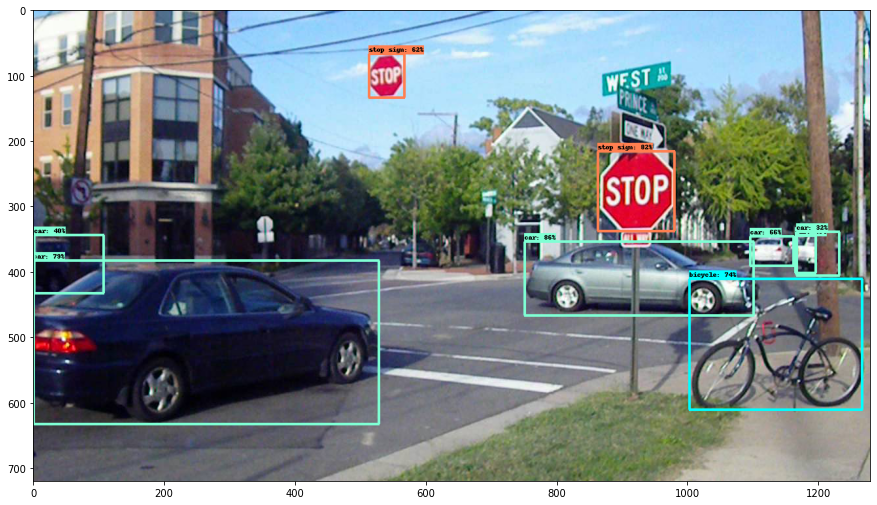

In [24]:
object_detection(IMAGE_PATHS[0])